# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
# Add as many code cells as you need
df = pd.read_csv('milestone_1_zillow.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77070 entries, 0 to 77069
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   bathroomcnt                       77070 non-null  int64  
 1   bedroomcnt                        77070 non-null  int64  
 2   buildingqualitytypeid             77070 non-null  float64
 3   calculatedfinishedsquarefeet      77070 non-null  float64
 4   fireplacecnt                      77070 non-null  int64  
 5   garagecarcnt                      77070 non-null  int64  
 6   garagetotalsqft                   77070 non-null  float64
 7   lotsizesquarefeet                 77070 non-null  float64
 8   roomcnt                           77070 non-null  int64  
 9   threequarterbathnbr               77070 non-null  int64  
 10  unitcnt                           77070 non-null  int64  
 11  yearbuilt                         77070 non-null  float64
 12  numb

In [3]:
# train_test_split set up 
X = df.drop(columns=['taxvaluedollarcnt'])
y = df['taxvaluedollarcnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((61656, 40), (15414, 40), (61656,), (15414,))

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,...,heatingorsystemtypeid_24.0,regionidcounty_1286.0,regionidcounty_2061.0,regionidcounty_3101.0,log_garagetotalsqft,log_lotsizesquarefeet,log_calculatedfinishedsquarefeet,calc_bedbath,prod_bathroomcnt_bedroomcnt,prod_fireplacecnt_garagecarcnt
0,-0.279573,-0.060467,0.610263,-0.081186,-0.181079,0.449537,0.536291,-0.252031,1.590810,-0.026946,...,-0.104339,1.678462,-0.29788,-1.382556,0.547220,-0.199303,0.140107,-0.379626,-0.270728,0.090455
1,-0.279573,-0.060467,0.610263,-0.494301,-0.181079,0.449537,0.649533,-0.279582,1.590810,-0.026946,...,-0.104339,1.678462,-0.29788,-1.382556,0.580913,-0.524299,-0.440730,-0.379626,-0.270728,0.090455
2,-0.279573,-0.060467,-0.677032,-0.472170,-0.181079,0.449537,0.029105,-0.271632,-0.525373,-0.026946,...,-0.104339,-0.595783,-0.29788,0.723298,0.360377,-0.414883,-0.405477,-0.379626,-0.270728,0.090455
3,0.730112,1.710615,-0.677032,0.527948,-0.181079,0.449537,0.765593,-0.243554,-0.525373,-0.026946,...,-0.104339,-0.595783,-0.29788,0.723298,0.613251,-0.122653,0.789979,-0.609151,1.180850,0.090455
4,-0.279573,-0.060467,0.610263,0.308744,-0.181079,0.449537,1.318369,-0.210376,-0.525373,-0.026946,...,-0.104339,1.678462,-0.29788,-1.382556,0.743898,0.118019,0.577233,-0.379626,-0.270728,0.090455


In [5]:
X_test_scaled.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,...,heatingorsystemtypeid_24.0,regionidcounty_1286.0,regionidcounty_2061.0,regionidcounty_3101.0,log_garagetotalsqft,log_lotsizesquarefeet,log_calculatedfinishedsquarefeet,calc_bedbath,prod_bathroomcnt_bedroomcnt,prod_fireplacecnt_garagecarcnt
0,-0.279573,-0.060467,-0.677032,-0.254020,-0.181079,0.449537,0.033489,-0.277522,-0.525373,-0.026946,...,-0.104339,-0.595783,-0.29788,0.723298,0.362329,-0.494350,-0.084838,-0.379626,-0.270728,0.090455
1,-0.279573,-0.060467,-0.677032,0.044224,-0.181079,0.449537,0.008199,-0.243537,-0.525373,-0.026946,...,-0.104339,-0.595783,-0.29788,0.723298,0.350963,-0.122511,0.290229,-0.379626,-0.270728,0.090455
2,-0.279573,-0.060467,0.610263,-0.305660,-0.181079,-1.365449,-1.095103,-0.308006,-0.525373,-0.026946,...,-0.104339,1.678462,-0.29788,-1.382556,-2.539603,-1.151992,-0.156688,-0.379626,-0.270728,-0.768753
3,-1.289257,-0.946007,-1.320680,-0.160226,-0.181079,-1.365449,-0.506671,-0.267224,-0.525373,-0.026946,...,-0.104339,-0.595783,-0.29788,0.723298,0.036118,-0.360588,0.040036,-0.953437,-0.915874,-0.768753
4,-0.279573,-0.946007,-0.033385,-0.503786,-0.181079,-1.365449,-0.296692,-0.136020,-0.525373,-0.026946,...,-0.104339,-0.595783,-0.29788,0.723298,0.188854,0.475032,-0.456011,0.767997,-0.593301,-0.768753


In [6]:
selected_features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'lotsizesquarefeet', 'roomcnt', 'threequarterbathnbr', 'unitcnt',
       'yearbuilt'] #if we want to subset by the best features identfied by the forward feature selection in milestone 1
X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]
X_train_scaled_selected.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,unitcnt,yearbuilt
0,-0.279573,-0.060467,-0.081186,-0.181079,0.449537,0.536291,-0.252031,1.590810,-0.026946,-0.070276,-0.401958
1,-0.279573,-0.060467,-0.494301,-0.181079,0.449537,0.649533,-0.279582,1.590810,-0.026946,-0.070276,-0.317900
2,-0.279573,-0.060467,-0.472170,-0.181079,0.449537,0.029105,-0.271632,-0.525373,-0.026946,-0.070276,-0.864274
3,0.730112,1.710615,0.527948,-0.181079,0.449537,0.765593,-0.243554,-0.525373,-0.026946,0.912472,-0.822246
4,-0.279573,-0.060467,0.308744,-0.181079,0.449537,1.318369,-0.210376,-0.525373,-0.026946,-0.070276,1.783539


In [7]:
X_test_scaled_selected.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,unitcnt,yearbuilt
0,-0.279573,-0.060467,-0.254020,-0.181079,0.449537,0.033489,-0.277522,-0.525373,-0.026946,-0.070276,-1.032389
1,-0.279573,-0.060467,0.044224,-0.181079,0.449537,0.008199,-0.243537,-0.525373,-0.026946,-0.070276,-0.612102
2,-0.279573,-0.060467,-0.305660,-0.181079,-1.365449,-1.095103,-0.308006,-0.525373,-0.026946,-0.070276,0.900934
3,-1.289257,-0.946007,-0.160226,-0.181079,-1.365449,-0.506671,-0.267224,-0.525373,-0.026946,-0.070276,-1.914994
4,-0.279573,-0.946007,-0.503786,-0.181079,-1.365449,-0.296692,-0.136020,-0.525373,-0.026946,-0.070276,-0.275871


### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [8]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(alpha=1.0, max_iter=10000),
    'Decision Tree': DecisionTreeRegressor(),
    'Bagging': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Set up cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# RMSE scorer (neg_root_mean_squared_error because sklearn minimizes loss)
scorer = make_scorer(mean_squared_error, squared=False)

# Store results
results = []

for name, model in models.items():
    # Now using n_jobs=-1 to parallelize cross-validation internally
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = -scores  # convert to positive RMSE

    results.append({
        'Model': name,
        'Mean RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

# Results into a dataframe
results_df = pd.DataFrame(results)

print(results_df)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+15, tolerance: 1.869e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.827e+15, tolerance: 1.976e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

               Model      Mean RMSE      Std RMSE
0  Linear Regression  492436.605762  37149.880023
1   Ridge Regression  492451.113914  37172.775903
2   Lasso Regression  492439.232533  37153.214063
3      Decision Tree  633318.025440  40894.787914
4            Bagging  479898.506465  30350.195686
5      Random Forest  461204.391054  31095.520128
6  Gradient Boosting  458965.932868  33887.509437


### Part 1: Discussion [2 pts] (Matt)

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?

  - Which are most stable (lowest std)?

  - Any signs of overfitting or underfitting?


> Overall, the best three models were, in order, the Gradient Boosting Regressor, the Random Forest Regressor, and the Bagging Regressor. They had the three lowest average Root Mean Squared Errors.

> The three most stable were the same 3 as the previous question, just in the opposite order. This is a great reason to continue testing features and parameters to determine which is the true best model.

> Since it is relatively stable, but with a high avg MSE, the Decision Tree was likely overfitting. It is difficult to tell for the others, but there is likely over/underfitting to some extent leading to the other worse RMSE's.

### Part 2: Feature Engineering [3 pts] (Matt)

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [9]:
# Feature Engineering Functions

# Log Feature Function
def log_transform_feature(df, feature):
  '''
  This log transforms a feature to create a new feature in a DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    feature (str): The name of the feature to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  df = df.copy()
  if feature not in df.columns:
    raise ValueError('Error: Features (bed and bath) not found.')
  else:
    new_name = 'log_' + feature
    df[new_name] = np.log1p(df[feature])
    df[new_name] = df[new_name].fillna(1)
    df[new_name] = df[new_name].replace([np.inf, -np.inf], 1)
    return df.copy()

# BedBath Calc Function
def calc_bedbath_feature(df, bedname, bathname):
  '''
  This calculates the number of beds over the number of baths to create a new feature in the DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    bedname (str): The name of one the features to be transformed.
    bathname (str): The name of one the features to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  df = df.copy()
  if bedname not in df.columns and bathname not in df.columns:
    raise ValueError('Error: Features (bed and bath) not found.')
  else:
    new_name = 'calc_bedbath'
    df[new_name] = df[bedname] / df[bathname]
    df[new_name] = df[new_name].fillna(1)
    df[new_name] = df[new_name].replace([np.inf, -np.inf], 1)
    return df

# Polynomial Feature Function - Product
def calc_product_feature(df, feature1, feature2):
  '''
  This calculates the product of two to create a new feature in a DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    feature1 (str): The name of one the features to be transformed.
    feature2 (str): The name of one the features to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  df = df.copy()
  if feature1 not in df.columns and feature2 not in df.columns:
    raise ValueError('Error: Features (bed and bath) not found.')
  else:
    new_name = 'prod_' + feature1 + '_' + feature2
    df[new_name] = df[feature1] * df[feature2]
    df[new_name] = df[new_name].fillna(1)
    return df
  
# Calculate Age instead of year built
def calc_age_feature(df, yearbuiltfeature):
  '''
  This calculates the Age from the yearbuilt in a DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    yearbuiltfeature (str): The name of the feature to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  df = df.copy()
  if yearbuiltfeature not in df.columns:
    raise ValueError('Error: Features (yearbuilt) not found.')
  new_name = 'age'
  df[new_name] = (2025 - df[yearbuiltfeature])
  return df

In [10]:
# Engineering Features

# bath bath Poly
X_eng = calc_product_feature(X, 'bathroomcnt', 'bathroomcnt') # Improved fstat

# bed bed poly
X_eng = calc_product_feature(X_eng, 'bedroomcnt', 'bedroomcnt')

# floors floors poly
X_eng = calc_product_feature(X_eng, 'numberofstories', 'numberofstories') # Improved Fstat
# X_eng = calc_product_feature(X_eng, 'numberofstories', 'prod_numberofstories_numberofstories') --- worse fstat

# floors log
# X_eng = log_transform_feature(X_eng, 'numberofstories') --- worse fstat

# Age feature
X_eng = calc_age_feature(X_eng, 'yearbuilt') # similar fstat, but necessary for improvement seen in next line
X_eng = log_transform_feature(X_eng, 'age') # improved fstat
# X_eng = calc_product_feature(X_eng, 'age', 'age') --- worse fstat

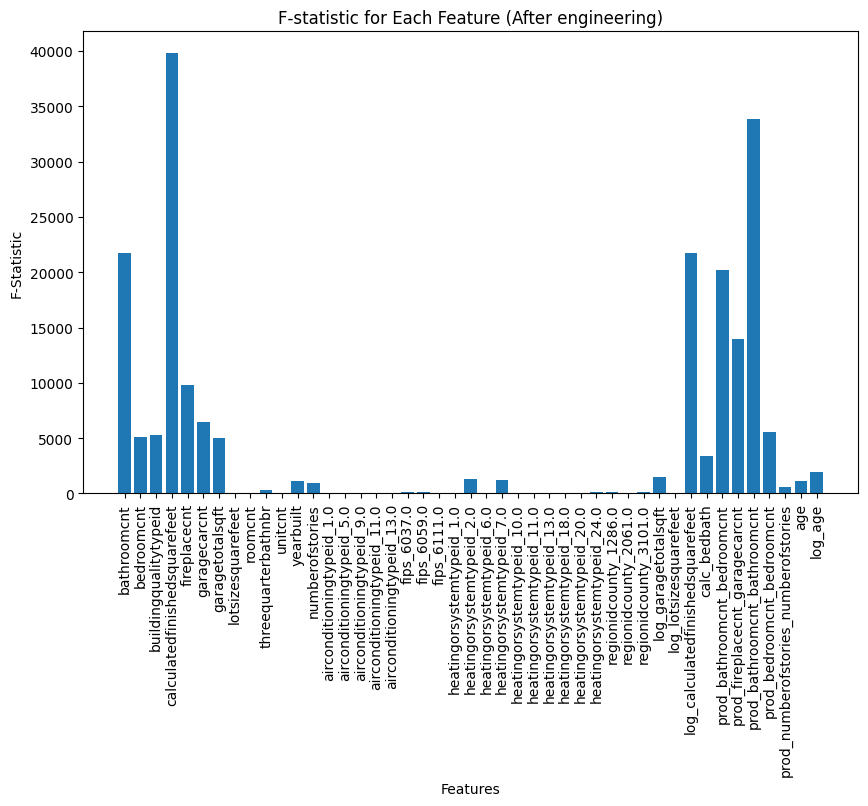

In [11]:
# Fstatistics for Features
fstats, pvalues = f_regression(X_eng, y)
f_statistics = pd.DataFrame({'feature': X_eng.columns, 'f': fstats})

# Ploting the F's
plt.figure(figsize=(10, 6))
plt.bar(f_statistics['feature'], f_statistics['f'])
plt.title('F-statistic for Each Feature (After engineering)')
plt.xlabel('Features')
plt.ylabel('F-Statistic')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [12]:
# Drop poorly engineered features
X_eng_dropped = X_eng.drop(columns=['log_calculatedfinishedsquarefeet', 'bathroomcnt', 'yearbuilt', 'numberofstories', 'calc_bedbath', 'fireplacecnt',
                                     'garagecarcnt', 'prod_bathroomcnt_bedroomcnt', 'bedroomcnt', 'log_garagetotalsqft', 'log_lotsizesquarefeet']) # Dropping redundant or poor fstat columns

In [13]:
# Standard Scaler
X_eng_train, X_eng_test, y_train, y_test = train_test_split(X_eng, y, test_size=0.2, random_state=random_state)
X_eng_train.shape, X_eng_test.shape, y_train.shape, y_test.shape

X_eng_dropped_train, X_eng_dropped_test, y_train, y_test = train_test_split(X_eng_dropped, y, test_size=0.2, random_state=random_state)
X_eng_dropped_train.shape, X_eng_dropped_test.shape, y_train.shape, y_test.shape

scaler2 = StandardScaler()
X_eng_train_scaled = scaler2.fit_transform(X_eng_train)
X_eng_test_scaled = scaler2.transform(X_eng_test)
X_eng_train_scaled = pd.DataFrame(X_eng_train_scaled, columns=X_eng_train.columns)
X_eng_test_scaled = pd.DataFrame(X_eng_test_scaled, columns=X_eng_test.columns)
X_eng_train_scaled.head()

scaler3 = StandardScaler()
X_eng_dropped_train_scaled = scaler3.fit_transform(X_eng_dropped_train)
X_eng_dropped_test_scaled = scaler3.transform(X_eng_dropped_test)
X_eng_dropped_train_scaled = pd.DataFrame(X_eng_dropped_train_scaled, columns=X_eng_dropped_train.columns)
X_eng_dropped_test_scaled = pd.DataFrame(X_eng_dropped_test_scaled, columns=X_eng_dropped_test.columns)
X_eng_dropped_train_scaled.head()

,buildingqualitytypeid,calculatedfinishedsquarefeet,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,unitcnt,airconditioningtypeid_1.0,airconditioningtypeid_5.0,airconditioningtypeid_9.0,...,heatingorsystemtypeid_24.0,regionidcounty_1286.0,regionidcounty_2061.0,regionidcounty_3101.0,prod_fireplacecnt_garagecarcnt,prod_bathroomcnt_bathroomcnt,prod_bedroomcnt_bedroomcnt,prod_numberofstories_numberofstories,age,log_age
0,0.610263,-0.081186,0.536291,-0.252031,1.590810,-0.026946,-0.070276,0.154861,-0.046844,-0.018458,...,-0.104339,1.678462,-0.29788,-1.382556,0.090455,-0.346420,-0.198940,-0.264011,0.401958,0.535628
1,0.610263,-0.494301,0.649533,-0.279582,1.590810,-0.026946,-0.070276,0.154861,-0.046844,-0.018458,...,-0.104339,1.678462,-0.29788,-1.382556,0.090455,-0.346420,-0.198940,-0.264011,0.317900,0.471802
2,-0.677032,-0.472170,0.029105,-0.271632,-0.525373,-0.026946,-0.070276,0.154861,-0.046844,-0.018458,...,-0.104339,-0.595783,-0.29788,0.723298,0.090455,-0.346420,-0.198940,-0.264011,0.864274,0.855789
3,-0.677032,0.527948,0.765593,-0.243554,-0.525373,-0.026946,0.912472,0.154861,-0.046844,-0.018458,...,-0.104339,-0.595783,-0.29788,0.723298,0.090455,0.453574,1.684996,-0.264011,0.822246,0.828613
4,0.610263,0.308744,1.318369,-0.210376,-0.525373,-0.026946,-0.070276,0.154861,-0.046844,-0.018458,...,-0.104339,1.678462,-0.29788,-1.382556,0.090455,-0.346420,-0.198940,-0.264011,-1.783539,-2.616449


In [14]:
# Rerun all models

# Store results
results2 = []
results3 = []

# Running all features
for name, model in models.items():
    # Now using n_jobs=-1 to parallelize cross-validation internally
    scores = cross_val_score(model, X_eng_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = -scores  # convert to positive RMSE

    results2.append({
        'Model': name,
        'Mean RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

# Results into a dataframe
results_df2 = pd.DataFrame(results2)

# Running w features dropped
for name, model in models.items():
    # Now using n_jobs=-1 to parallelize cross-validation internally
    scores = cross_val_score(model, X_eng_dropped_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = -scores  # convert to positive RMSE

    results3.append({
        'Model': name,
        'Mean RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

# Results into a dataframe
results_df3 = pd.DataFrame(results3)

print(f"All features:\n{results_df2}\n\nFeatures Dropped:\n{results_df3}")

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.269e+12, tolerance: 1.979e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+14, tolerance: 1.832e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

KeyboardInterrupt: 

In [15]:
# Nowrin did this. Delete later

# Rerun all models

# Store results
results2 = []
results3 = []

# Running all features
for name, model in models.items():
    # Now using n_jobs=-1 to parallelize cross-validation internally
    if name == 'Ridge Regression' or name == 'Lasso Regression':
        # Increase max_iter to handle convergence issues
        if name == 'Ridge Regression':
            model.set_params(max_iter=10000)  # Increase max_iter for Ridge
        elif name == 'Lasso Regression':
            model.set_params(alpha=1.0, max_iter=10000)  # Increase max_iter for Lasso

    scores = cross_val_score(model, X_eng_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = -scores  # convert to positive RMSE

    results2.append({
        'Model': name,
        'Mean RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

# Results into a dataframe
results_df2 = pd.DataFrame(results2)

# Running with features dropped
for name, model in models.items():
    # Now using n_jobs=-1 to parallelize cross-validation internally
    if name == 'Ridge Regression' or name == 'Lasso Regression':
        # Increase max_iter to handle convergence issues
        if name == 'Ridge Regression':
            model.set_params(max_iter=10000)  # Increase max_iter for Ridge
        elif name == 'Lasso Regression':
            model.set_params(alpha=1.0, max_iter=10000)  # Increase max_iter for Lasso

    scores = cross_val_score(model, X_eng_dropped_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = -scores  # convert to positive RMSE

    results3.append({
        'Model': name,
        'Mean RMSE': np.mean(rmse_scores),
        'Std RMSE': np.std(rmse_scores)
    })

# Results into a dataframe
results_df3 = pd.DataFrame(results3)

print(f"All features:\n{results_df2}\n\nFeatures Dropped:\n{results_df3}")

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+14, tolerance: 1.832e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.269e+12, tolerance: 1.979e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

All features:
               Model      Mean RMSE      Std RMSE
0  Linear Regression  485070.550373  34543.447420
1   Ridge Regression  485070.131996  34545.823587
2   Lasso Regression  485069.113842  34542.833233
3      Decision Tree  635694.902986  40388.182569
4            Bagging  480302.045388  30541.817557
5      Random Forest  460698.358823  29658.566024
6  Gradient Boosting  459084.844758  34086.439425

Features Dropped:
               Model      Mean RMSE      Std RMSE
0  Linear Regression  493890.190591  39086.432300
1   Ridge Regression  493884.468683  39079.771621
2   Lasso Regression  493888.166779  39084.205118
3      Decision Tree  636102.445901  34927.107894
4            Bagging  478135.805583  28141.560943
5      Random Forest  460049.349360  30463.022602
6  Gradient Boosting  460852.107403  30310.939550


### Part 2: Discussion [2 pts] (Matt)

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



> Your text here

### Part 3: Feature Selection [3 pts] (Nowrin)

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.



Running Forward Feature Selection for Linear Regression...

Step 1: Added calculatedfinishedsquarefeet | RMSE: 506560.7697
Step 2: Added prod_bedroomcnt_bedroomcnt | RMSE: 498687.8820
Step 3: Added prod_bathroomcnt_bathroomcnt | RMSE: 489624.3068
Step 4: Added age | RMSE: 488571.7734
Step 5: Added buildingqualitytypeid | RMSE: 486803.7782
Step 6: Added heatingorsystemtypeid_7.0 | RMSE: 485215.3247
Step 7: Added log_age | RMSE: 484184.0527
Step 8: Added roomcnt | RMSE: 483894.1305
Step 9: Added fips_6059.0 | RMSE: 483472.1795
Step 10: Added prod_fireplacecnt_garagecarcnt | RMSE: 483316.7650
Step 11: Added airconditioningtypeid_13.0 | RMSE: 483237.3701
Step 12: Added threequarterbathnbr | RMSE: 483160.5724
Step 13: Added garagetotalsqft | RMSE: 483125.5096
Step 14: Added lotsizesquarefeet | RMSE: 482515.5564
Step 15: Added prod_numberofstories_numberofstories | RMSE: 482458.9168
Step 16: Added heatingorsystemtypeid_24.0 | RMSE: 482420.8932
Step 17: Added airconditioningtypeid_11.0 | RMS

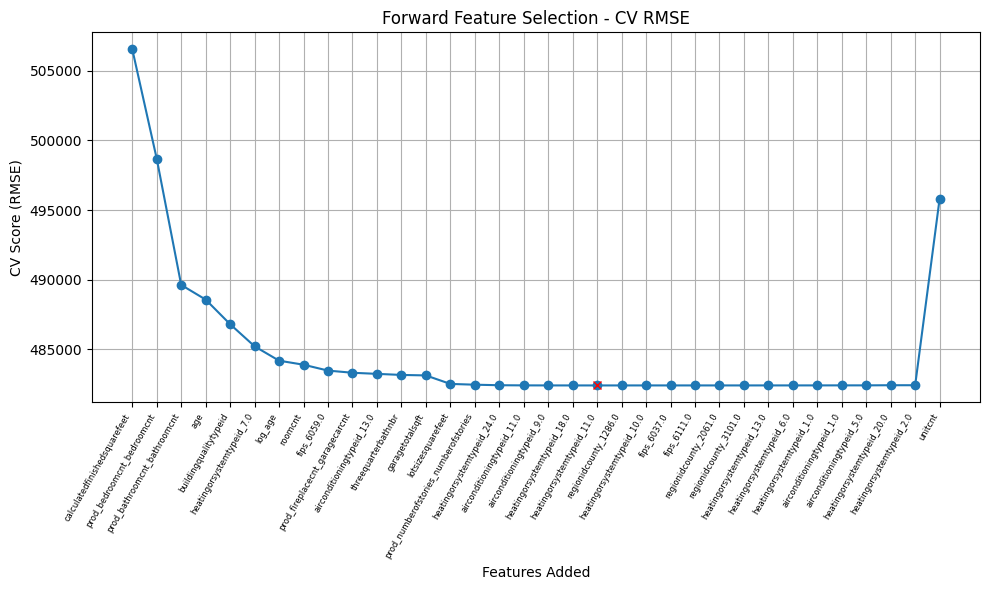

Best Subset of Features for Linear Regression: ['calculatedfinishedsquarefeet', 'prod_bedroomcnt_bedroomcnt', 'prod_bathroomcnt_bathroomcnt', 'age', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'log_age', 'roomcnt', 'fips_6059.0', 'prod_fireplacecnt_garagecarcnt', 'airconditioningtypeid_13.0', 'threequarterbathnbr', 'garagetotalsqft', 'lotsizesquarefeet', 'prod_numberofstories_numberofstories', 'heatingorsystemtypeid_24.0', 'airconditioningtypeid_11.0', 'airconditioningtypeid_9.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_11.0']
Best CV RMSE: 482406.3235



In [16]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

def forward_feature_selection(X_train, y_train, model, 
                              scoring='neg_mean_squared_error', 
                              cv_folds=5, 
                              tol=None,
                              max_features=None,
                              verbose=False):
    
    selected_features = []                         
    remaining_features = list(X_train.columns)     
    rmse_history = []                              
    prev_rmse = float('inf')                       

    best_subset = None                            
    best_rmse = float('inf')                       

    # Cross-validation strategy
    cv = RepeatedKFold(n_splits=cv_folds, n_repeats=1, random_state=42)

    while remaining_features:
        scores = {}
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            mse_scores = cross_val_score(model, X_train[trial_features], y_train,
                                         scoring=scoring, cv=cv, n_jobs=-1)
            rmse_score = np.sqrt(-np.mean(mse_scores))  # Convert to RMSE
            scores[feature] = rmse_score

        best_feature = min(scores, key=scores.get)
        current_rmse = scores[best_feature]

        # Early stopping based on tolerance
        if tol is not None and (prev_rmse - current_rmse < tol):
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        selected_features.append(best_feature)
        rmse_history.append(current_rmse)
        remaining_features.remove(best_feature)
        prev_rmse = current_rmse

        if verbose:
            print(f"Step {len(selected_features)}: Added {best_feature} | RMSE: {current_rmse:.4f}")

        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_subset = selected_features.copy()

        if max_features is not None and len(selected_features) >= max_features:
            break

    # Plotting
    if best_subset:
        best_index = selected_features.index(best_subset[-1])
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(rmse_history) + 1), rmse_history, marker='o')
        plt.plot([best_index + 1], [best_rmse], marker='x', color='red')  # Highlight best RMSE
        plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=60, ha='right', fontsize=6)
        plt.title('Forward Feature Selection - CV RMSE')
        plt.xlabel('Features Added')
        plt.ylabel('CV Score (RMSE)')
        plt.grid()
        plt.tight_layout()
        plt.show()

    return best_subset, best_rmse, rmse_history


# Define models
models = {
    'Linear Regression': LinearRegression()
}

# Define thresholds 
tol_value = None    
max_features_value = None 

# Dictionary to store results
results_forward_selection = {}

for name, model in models.items():
    print(f"\nRunning Forward Feature Selection for {name}...\n")
    best_subset, best_rmse, rmse_history = forward_feature_selection(
        X_eng_dropped_train_scaled, y_train, model,  # Use cleaned feature set
        tol=tol_value,                
        max_features=max_features_value,  
        verbose=True
    )
    
    results_forward_selection[name] = {
        'best_subset': best_subset,
        'best_rmse': best_rmse
    }
    
    print(f"Best Subset of Features for {name}: {best_subset}")
    print(f"Best CV RMSE: {best_rmse:.4f}\n")

In [21]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def forward_feature_selection(X_train, y_train, model, 
                              scoring='neg_mean_squared_error', 
                              cv_folds=5, 
                              tol=None,
                              max_features=None,
                              verbose=False):
    
    selected_features = []                         
    remaining_features = list(X_train.columns)     
    rmse_history = []                              
    prev_rmse = float('inf')                       

    best_subset = None                            
    best_rmse = float('inf')                       

    # Cross-validation strategy
    cv = RepeatedKFold(n_splits=cv_folds, n_repeats=1, random_state=42)

    while remaining_features:
        scores = {}
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            mse_scores = cross_val_score(model, X_train[trial_features], y_train,
                                         scoring=scoring, cv=cv, n_jobs=-1)
            rmse_score = np.sqrt(-np.mean(mse_scores))  # Convert to RMSE
            scores[feature] = rmse_score

        best_feature = min(scores, key=scores.get)
        current_rmse = scores[best_feature]

        # Early stopping based on tolerance
        if tol is not None and (prev_rmse - current_rmse < tol):
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        selected_features.append(best_feature)
        rmse_history.append(current_rmse)
        remaining_features.remove(best_feature)
        prev_rmse = current_rmse

        if verbose:
            print(f"Step {len(selected_features)}: Added {best_feature} | RMSE: {current_rmse:.4f}")

        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_subset = selected_features.copy()

        if max_features is not None and len(selected_features) >= max_features:
            break

    # Plotting
    if best_subset:
        best_index = selected_features.index(best_subset[-1])
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(rmse_history) + 1), rmse_history, marker='o')
        plt.plot([best_index + 1], [best_rmse], marker='x', color='red')  # Highlight best RMSE
        plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=60, ha='right', fontsize=6)
        plt.title('Forward Feature Selection - CV RMSE')
        plt.xlabel('Features Added')
        plt.ylabel('CV Score (RMSE)')
        plt.grid()
        plt.tight_layout()
        plt.show()

    return best_subset, best_rmse, rmse_history

In [23]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(alpha=1.0, max_iter=10000),
    'Decision Tree': DecisionTreeRegressor(),
    'Bagging': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}



Running Forward Feature Selection for Linear Regression...



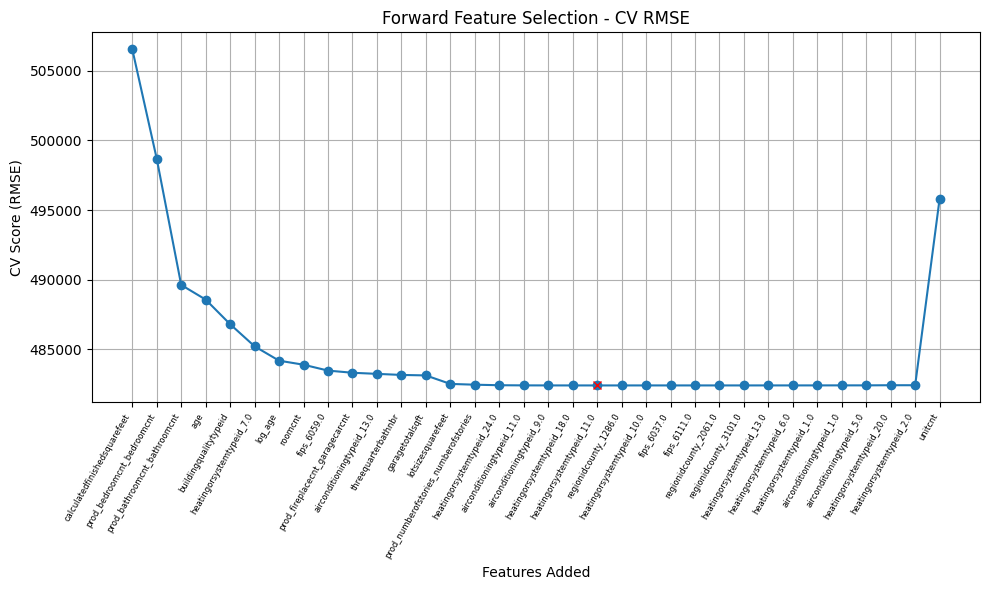

Best Subset of Features for Linear Regression: ['calculatedfinishedsquarefeet', 'prod_bedroomcnt_bedroomcnt', 'prod_bathroomcnt_bathroomcnt', 'age', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'log_age', 'roomcnt', 'fips_6059.0', 'prod_fireplacecnt_garagecarcnt', 'airconditioningtypeid_13.0', 'threequarterbathnbr', 'garagetotalsqft', 'lotsizesquarefeet', 'prod_numberofstories_numberofstories', 'heatingorsystemtypeid_24.0', 'airconditioningtypeid_11.0', 'airconditioningtypeid_9.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_11.0']
Best CV RMSE: 482406.3235


Running Forward Feature Selection for Ridge Regression...



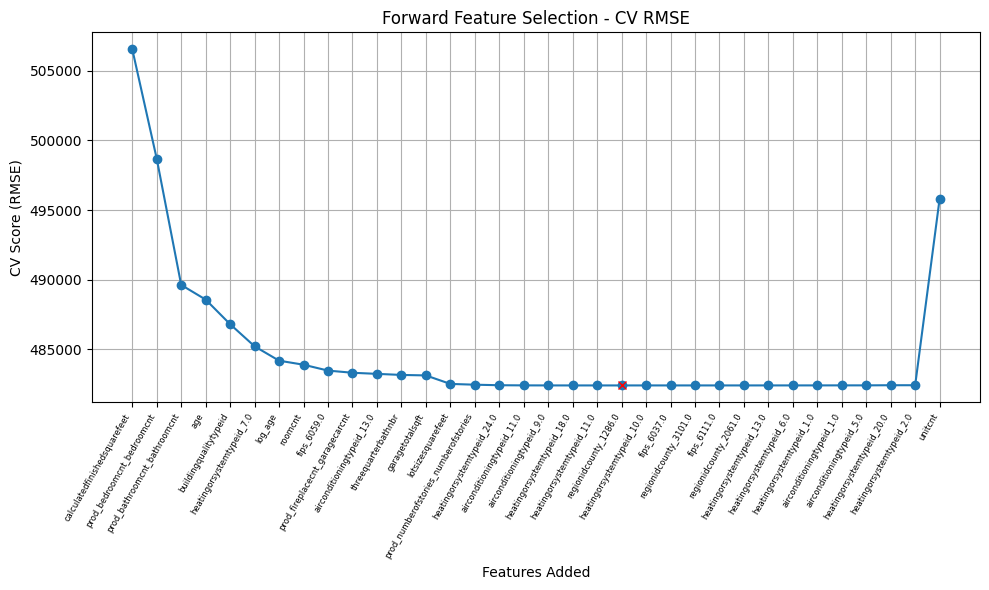

Best Subset of Features for Ridge Regression: ['calculatedfinishedsquarefeet', 'prod_bedroomcnt_bedroomcnt', 'prod_bathroomcnt_bathroomcnt', 'age', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'log_age', 'roomcnt', 'fips_6059.0', 'prod_fireplacecnt_garagecarcnt', 'airconditioningtypeid_13.0', 'threequarterbathnbr', 'garagetotalsqft', 'lotsizesquarefeet', 'prod_numberofstories_numberofstories', 'heatingorsystemtypeid_24.0', 'airconditioningtypeid_11.0', 'airconditioningtypeid_9.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_11.0', 'regionidcounty_1286.0']
Best CV RMSE: 482406.2545


Running Forward Feature Selection for Lasso Regression...



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.599e+13, tolerance: 1.979e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.599e+13, tolerance: 1.979e+12
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

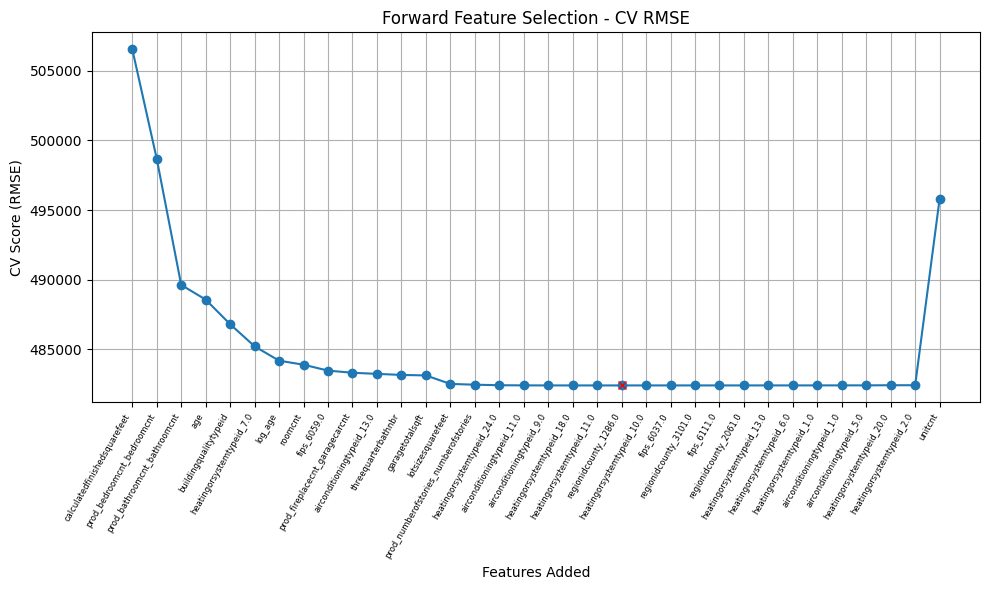

Best Subset of Features for Lasso Regression: ['calculatedfinishedsquarefeet', 'prod_bedroomcnt_bedroomcnt', 'prod_bathroomcnt_bathroomcnt', 'age', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'log_age', 'roomcnt', 'fips_6059.0', 'prod_fireplacecnt_garagecarcnt', 'airconditioningtypeid_13.0', 'threequarterbathnbr', 'garagetotalsqft', 'lotsizesquarefeet', 'prod_numberofstories_numberofstories', 'heatingorsystemtypeid_24.0', 'airconditioningtypeid_11.0', 'airconditioningtypeid_9.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_11.0', 'regionidcounty_1286.0']
Best CV RMSE: 482406.3169


Running Forward Feature Selection for Decision Tree...



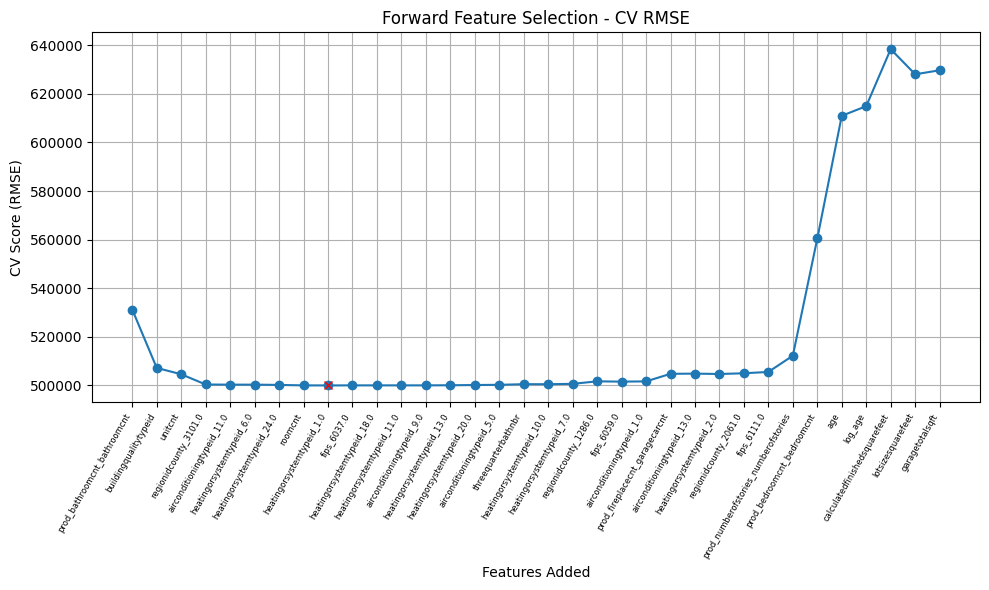

Best Subset of Features for Decision Tree: ['prod_bathroomcnt_bathroomcnt', 'buildingqualitytypeid', 'unitcnt', 'regionidcounty_3101.0', 'airconditioningtypeid_11.0', 'heatingorsystemtypeid_6.0', 'heatingorsystemtypeid_24.0', 'roomcnt', 'heatingorsystemtypeid_1.0']
Best CV RMSE: 499947.8091


Running Forward Feature Selection for Bagging...



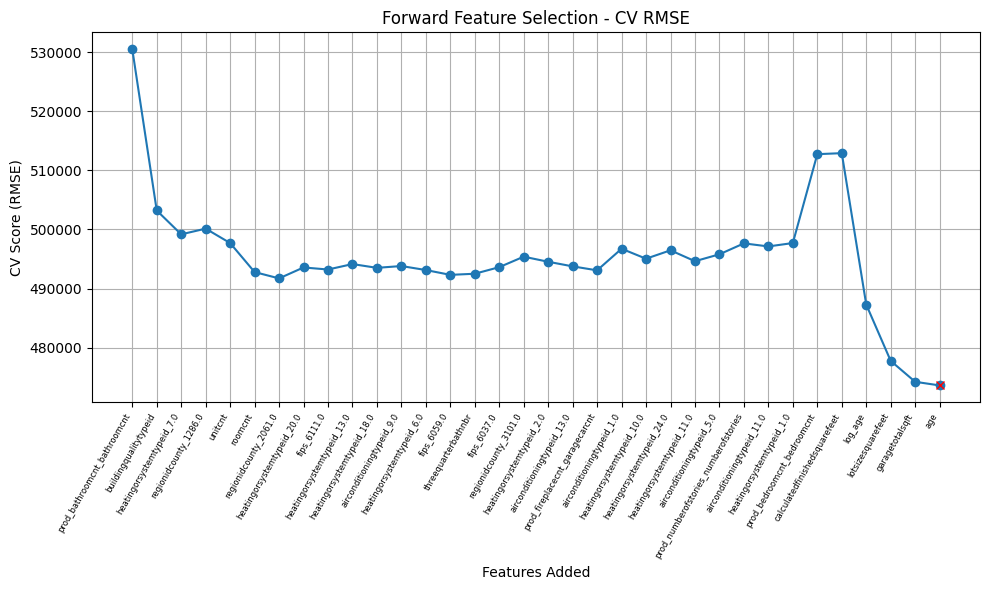

Best Subset of Features for Bagging: ['prod_bathroomcnt_bathroomcnt', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'regionidcounty_1286.0', 'unitcnt', 'roomcnt', 'regionidcounty_2061.0', 'heatingorsystemtypeid_20.0', 'fips_6111.0', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_18.0', 'airconditioningtypeid_9.0', 'heatingorsystemtypeid_6.0', 'fips_6059.0', 'threequarterbathnbr', 'fips_6037.0', 'regionidcounty_3101.0', 'heatingorsystemtypeid_2.0', 'airconditioningtypeid_13.0', 'prod_fireplacecnt_garagecarcnt', 'airconditioningtypeid_1.0', 'heatingorsystemtypeid_10.0', 'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_11.0', 'airconditioningtypeid_5.0', 'prod_numberofstories_numberofstories', 'airconditioningtypeid_11.0', 'heatingorsystemtypeid_1.0', 'prod_bedroomcnt_bedroomcnt', 'calculatedfinishedsquarefeet', 'log_age', 'lotsizesquarefeet', 'garagetotalsqft', 'age']
Best CV RMSE: 473623.0984


Running Forward Feature Selection for Random Forest...



/home/codespace/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Define thresholds 
tol_value = None    
max_features_value = None 

# Dictionary to store results
results_forward_selection = {}

for name, model in models.items():
    print(f"\nRunning Forward Feature Selection for {name}...\n")
    best_subset, best_rmse, rmse_history = forward_feature_selection(
        X_eng_dropped_train_scaled, y_train, model,  # Use cleaned feature set
        tol=tol_value,                
        max_features=max_features_value,  
        verbose=False
    )
    
    results_forward_selection[name] = {
        'best_subset': best_subset,
        'best_rmse': best_rmse
    }
    
    print(f"Best Subset of Features for {name}: {best_subset}")
    print(f"Best CV RMSE: {best_rmse:.4f}\n")

### Part 3: Discussion [2 pts] (Nowrin)

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> Your text here

### Part 4: Fine-Tuning Your Top 3 Models [6 pts] (Peter)

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [ ]:
# Add as many code cells as you need

### Part 4: Discussion [4 pts] (Peter)

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

> Your text here